# **Twitter Sentiment Analysis with Logistic Regression**

To obtein the twitter dataset we use an open-source python library called
Natural Language Toolkit (NLTK).

NLTK allows to get the list of positive tweets and the list of negative tweets.

Every tweet is a string which will be classified by the sentiment classifier based on logistic regression.

In [113]:
import nltk                              
from nltk.corpus import twitter_samples  
import random                       

nltk.download('twitter_samples') # dataset

positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')


Distribution of tweets

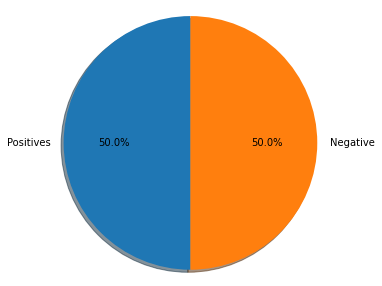

In [103]:
import matplotlib.pyplot as plt         

fig = plt.figure(figsize=(5, 5))
labels = 'Positives', 'Negative'
sizes = [len(positive_tweets), len(negative_tweets)]
plt.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')
plt.show()

DataFrame of tweets

In [104]:
import pandas as pd

d = {"tweet":positive_tweets+negative_tweets,"sentiment":["POS"]*5000+["NEG"]*5000}
df = pd.DataFrame(data=d)
df = df.sample(frac=1).reset_index(drop=True)
df

,tweet,sentiment
0,"Thank you :) ""@khuzy_k: @Miss_Sejeng Happy bir...",POS
1,#docopenhagen i have a horse in my ass :( http...,NEG
2,"@ellierowexo in this weather, are you mad? &am...",NEG
3,that means i will be on the low limit table fo...,NEG
4,@Awaishooo Shahid Afridi tou young hi hai na a...,POS
...,...,...
9995,i messed up big time :(,NEG
9996,Who even started this trend? I wanna know if t...,NEG
9997,so i have to survive another week without my p...,NEG
9998,FeyTyaz Follback ya :),POS


## **Text Processing**
Tweets data contain a lot if irrelevant information like hashtags, stop word, mentions, etc.

Data cleaning removes all these information, which are useless for the sentiment classifier.

In [114]:
import re               
import string
from nltk.corpus import stopwords  
from nltk.stem import PorterStemmer           
from nltk.tokenize import TweetTokenizer

nltk.download("stopwords")

def text_process(tweet):

  tweet = re.sub(r'^RT[\s]+', '', tweet) # no retweet texts
  tweet = re.sub(r'@[\w]+', '', tweet) # no mentions
  tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet) # no hyperlinks
  tweet = re.sub(r'#', '', tweet) # no hashtags
 
  tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
  tweet_tokens = tokenizer.tokenize(tweet) # split tweet

  stopwords_english = stopwords.words('english')
  stemmer = PorterStemmer() # no suffixes and prefixes
  pron = ['i', 'you','he','she','it','we','they']

  tweets_clean = []

  for word in tweet_tokens: # no stopwords no punctuation, no pronouns
      if (word not in stopwords_english and  word not in string.punctuation):  
          word = word.lower()
          if word in pron: continue
          tweets_clean.append(stemmer.stem(word))

  return tweets_clean
  
print(positive_tweets[1])
text_process(positive_tweets[1])

@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!


['hey',
 'jame',
 'odd',
 ':/',
 'pleas',
 'call',
 'contact',
 'centr',
 '02392441234',
 'abl',
 'assist',
 ':)',
 'mani',
 'thank']

## **Split training and testing**

In [106]:
import numpy as np  

# 80% training 
train_pos = positive_tweets[:4000]
train_neg = negative_tweets[:4000]

# 20% testing
test_pos = positive_tweets[4000:]
test_neg = negative_tweets[4000:]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

## **Dataset's Words Frequency**
Tweets can't be fed into the logistic regression function, because they are strings.

So let's create a dictionary, which contain the frequency of words in positive tweets and the frequency of words in negative tweets.

In [107]:
freqs = {}
words = []
for tweet in train_pos:
    tweet=text_process(tweet)
    for word in tweet:
        words.append(word)

for word in words: # count how many times "word" is used in the positive tweets
    if (word,1) not in freqs:
        freqs[(word,1)] = 1
    else:
        freqs[(word,1)] +=1

words=[]
for tweet in train_neg:
    tweet=text_process(tweet)
    for word in tweet:
        words.append(word)

for word in words: # count how many times "word" is used in the negative tweets
    if (word,0) not in freqs:
        freqs[(word,0)] = 1
    else:
        freqs[(word,0)] +=1

Each tweet is represented by a vector of frequencies, which can be fed into the logistic regression function.

In [108]:
def features_extraction(tweet, freqs):
    word_l = text_process(tweet)
    x = np.zeros((1, 3))
    x[0,0] = 1 
    for word in word_l:
        try:
            x[0,1] += freqs[(word,1)]
        except:
            x[0,1] += 0
        try: 
            x[0,2] += freqs[(word,0.0)]
        except:
            x[0,2] += 0
    assert(x.shape == (1, 3))
    return x
    
freq_positive_train = []
freq_negative_train = []

for tweet in train_x:
  x = features_extraction(tweet,freqs) 
  freq_positive_train.append(int(x[0,1])) 
  freq_negative_train.append(int(x[0,2])) 

In [109]:
d = {"tweet":train_x,"sentiment":["POS"]*4000+["NEG"]*4000,"freq_positive":freq_positive_train,"freq_negative":freq_negative_train}
df = pd.DataFrame(data=d)
df

,tweet,sentiment,freq_positive,freq_negative
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,POS,3020,61
1,@Lamb2ja Hey James! How odd :/ Please call our...,POS,3573,444
2,@DespiteOfficial we had a listen last night :)...,POS,3005,115
3,@97sides CONGRATS :),POS,2862,4
4,yeaaaah yippppy!!! my accnt verified rqst has...,POS,3119,225
...,...,...,...,...
7995,Amelia didnt stalk my twitter :(,NEG,29,3706
7996,"oh, i missed the broadcast. : (",NEG,62,323
7997,i really can't stream on melon i feel useless :-(,NEG,144,783
7998,I need to stop looking at old soccer pictures :(,NEG,205,3890


## **Logistic regression classifier**

In [116]:
def sigmoid(x): 
    h = 1/(1+np.exp(-x))
    return h

def learn(x, y, alpha, num_iters):
    theta = np.zeros((3, 1))
    m = x.shape[0]
    J = []
    for i in range(0, num_iters):
        z = np.dot(x,theta)
        h = sigmoid(z)
        J.append(-1/m*(np.dot(y.T,np.log(h))+np.dot((1-y).T,np.log(1-h))))
        theta -= (alpha/m)*np.dot(x.T,h-y)
    return J, theta

## **Training**

In [117]:
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= features_extraction(train_x[i], freqs)

J, theta = learn(X, train_y, 1e-9, 1500)

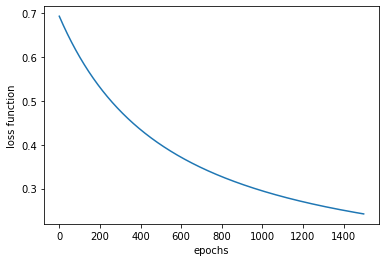

In [121]:
# cross entropy minimized
J = np.array(J).reshape(len(J))
plt.plot(range(len(J)),J)
plt.xlabel("epochs")
plt.ylabel("loss function")
plt.show()

## **Testing**

In [112]:
def predict(tweet, freqs, theta):
    x = features_extraction(tweet,freqs)
    y_pred = sigmoid(np.dot(x,theta))
    return y_pred

def test_accuracy(test_x, test_y, freqs, theta):
    y_hat = []
    for tweet in test_x:
        y_pred = predict(tweet, freqs, theta)
        if y_pred > 0.5:
            y_hat.append(1)
        else:
            y_hat.append(0)

    m=len(y_hat)
    y_hat=np.array(y_hat)
    y_hat=y_hat.reshape(m)
    test_y=test_y.reshape(m)

    c = y_hat == test_y
    j = 0
    for i in c:
        if i==True:
            j += 1
    accuracy = j/m
    return accuracy * 100

accuracy = test_accuracy(test_x, test_y, freqs, theta)
print("Accuracy :: {}%".format(accuracy))

Accuracy :: 99.5%
